# 作業 : (Kaggle)鐵達尼生存預測
***
- 以下用鐵達尼預測資料, 展示如何使用葉編碼, 並觀察預測效果
- 因為只有分類問題比較適合葉編碼, 因此範例與作業都使用鐵達尼的資料(二元分類問題)

In [1]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
# 因為擬合(fit)與編碼(transform)需要分開, 因此不使用.get_dummy, 而採用 sklearn 的 OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

data_path = 'data/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

C:\Users\erwin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\erwin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\erwin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\erwin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\erwin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to floa

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [3]:
train_X = df.values
train_X

array([[1.        , 0.12134831, 1.        , ..., 0.01415106, 0.        ,
        1.        ],
       [0.        , 0.21348315, 0.        , ..., 0.13913574, 0.55782313,
        0.33333333],
       [1.        , 0.39662921, 0.        , ..., 0.01546857, 0.        ,
        1.        ],
       ...,
       [1.        , 0.46404494, 0.        , ..., 0.04577135, 0.        ,
        1.        ],
       [0.        , 0.09101124, 1.        , ..., 0.0585561 , 0.41496599,
        0.33333333],
       [1.        , 0.24719101, 1.        , ..., 0.01512699, 0.        ,
        0.66666667]])

In [4]:
pd.DataFrame(train_X).describe()

,0,1,2,3,4,5,6,7,8,9
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.654321,0.500000,0.647587,0.303712,0.065376,0.063599,0.497836,0.062858,0.119929,0.843247
std,0.418036,0.289162,0.477990,0.220586,0.137843,0.134343,0.295369,0.096995,0.259458,0.266751
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.250000,0.000000,0.086420,0.000000,0.000000,0.233088,0.015440,0.000000,0.666667
50%,1.000000,0.500000,1.000000,0.308642,0.000000,0.000000,0.495588,0.028213,0.000000,1.000000
75%,1.000000,0.750000,1.000000,0.444444,0.125000,0.000000,0.763971,0.060508,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


------

## sklearn.model_selection.train_test_split(*arrays, **options)

Split arrays or matrices into random train and test subsets

Quick utility that wraps input validation and next(ShuffleSplit().split(X, y)) and application to input data into a single call for splitting (and optionally subsampling) data in a oneliner.

### Parameters:	
#### *arrays : sequence of indexables with same length / shape[0]
Allowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes.

#### test_size : float, int or None, optional (default=0.25)
If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split. If int, represents the absolute number of test samples. If None, the value is set to the complement of the train size. By default, the value is set to 0.25. The default will change in version 0.21. It will remain 0.25 only if train_size is unspecified, otherwise it will complement the specified train_size.

#### train_size : float, int, or None, (default=None)
If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split. If int, represents the absolute number of train samples. If None, the value is automatically set to the complement of the test size.

#### random_state : int, RandomState instance or None, optional (default=None)
If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.

#### shuffle : boolean, optional (default=True)
Whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.

#### stratify : array-like or None (default=None)
If not None, data is split in a stratified fashion, using this as the class labels.

### Returns:	
#### splitting : list, length=2 * len(arrays)
List containing train-test split of inputs.

New in version 0.16: If the input is sparse, the output will be a scipy.sparse.csr_matrix. Else, output type is the same as the input type.

------


In [5]:
# 因為訓練邏輯斯迴歸時也要資料, 因此將訓練及切成三部分 train / val / test, 採用 test 驗證而非 k-fold 交叉驗證
# train 用來訓練梯度提升樹, val 用來訓練邏輯斯迴歸, test 驗證效果

train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=0.5)

print(f'train_X.shape={train_X.shape}, test_X={test_X.shape}, train_Y={train_Y.shape}, test_Y={test_Y.shape}')

train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.5)

print(f'train_X.shape={train_X.shape}, val_X={val_X.shape}, train_Y={train_Y.shape}, val_Y={val_Y.shape}')



train_X.shape=(445, 10), test_X=(446, 10), train_Y=(445,), test_Y=(446,)
train_X.shape=(222, 10), val_X=(223, 10), train_Y=(222,), val_Y=(223,)


------

## sklearn.ensemble.GradientBoostingClassifier

### apply(X)
Apply trees in the ensemble to X, return leaf indices.

New in version 0.17.

### Parameters:	
#### X : {array-like, sparse matrix}, shape (n_samples, n_features)
The input samples. Internally, its dtype will be converted to dtype=np.float32. If a sparse matrix is provided, it will be converted to a sparse csr_matrix.

### Returns:	
#### X_leaves : array-like, shape (n_samples, n_estimators, n_classes)
For each datapoint x in X and for each tree in the ensemble, return the index of the leaf x ends up in each estimator. In the case of binary classification n_classes is 1.

------

In [6]:
# 梯度提升樹調整參數並擬合後, 再將葉編碼 (*.apply) 結果做獨熱 / 邏輯斯迴歸
# 調整參數的方式採用 RandomSearchCV 或 GridSearchCV, 以後的進度會再教給大家, 本次先直接使用調參結果
gdbt = GradientBoostingClassifier(subsample=0.93, n_estimators=320, min_samples_split=0.1, min_samples_leaf=0.3, 
                                  max_features=4, max_depth=4, learning_rate=0.16)

# Note: 先用 GDBT 來做 fit / regression, 得到 tree 
gdbt.fit(train_X, train_Y)

print(f'gdbt.apply(train_X).shape={gdbt.apply(train_X).shape}')
gdbt.apply(train_X)

print(f'gdbt.apply(train_X)[:, :, 0].shape={gdbt.apply(train_X)[:, :, 0].shape}')
gdbt.apply(train_X)[:, :, 0]

gdbt.apply(train_X).shape=(222, 320, 1)
gdbt.apply(train_X)[:, :, 0].shape=(222, 320)


array([[2., 2., 2., ..., 3., 4., 2.],
       [1., 1., 2., ..., 4., 2., 1.],
       [1., 1., 2., ..., 3., 4., 2.],
       ...,
       [2., 2., 1., ..., 4., 3., 1.],
       [2., 2., 2., ..., 3., 3., 2.],
       [2., 1., 2., ..., 4., 4., 1.]])

In [7]:
print(f'gdbt.apply(train_X)[0, :, 0].shape={gdbt.apply(train_X)[0, :, 0].shape}')
gdbt.apply(train_X)[0, :, 0]

gdbt.apply(train_X)[0, :, 0].shape=(320,)


array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2.,
       2., 2., 2., 4., 2., 2., 2., 1., 2., 1., 2., 1., 0., 2., 4., 2., 2.,
       1., 2., 2., 1., 1., 2., 3., 1., 2., 2., 2., 3., 1., 4., 1., 2., 2.,
       2., 1., 2., 2., 1., 2., 3., 2., 2., 2., 2., 1., 2., 1., 2., 2., 2.,
       2., 1., 3., 4., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 1., 2.,
       2., 1., 1., 4., 1., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 1., 2.,
       2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 1., 2., 2.,
       1., 2., 2., 2., 3., 2., 1., 3., 2., 1., 1., 2., 2., 2., 2., 1., 2.,
       1., 2., 2., 2., 2., 2., 3., 2., 1., 2., 2., 1., 4., 2., 4., 1., 1.,
       1., 2., 2., 2., 1., 2., 2., 3., 1., 2., 2., 2., 2., 1., 2., 4., 1.,
       1., 2., 1., 1., 2., 2., 1., 2., 3., 1., 4., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 1., 2., 1., 2., 2., 2., 4., 0., 2., 2.,
       2., 2., 2., 1., 2., 2., 2., 1., 1., 3., 1., 1., 2., 2., 2., 1., 2.,
       1., 2., 1., 1., 2.

In [8]:
# Note: 顯示 leaf 值的種類
pd.Series(gdbt.apply(train_X)[:, :, 0]).unique()

Exception: Data must be 1-dimensional

In [9]:
 
onehot = OneHotEncoder()
lr = LogisticRegression(solver='lbfgs', max_iter=1000)

# Note: 先用 OneHot Encoder 來 Encode GDBT 的 Leaf
enc = onehot.fit(gdbt.apply(train_X)[:, :, 0])

print(f'enc.n_values_.shape={enc.n_values_.shape}')

"""
enc.n_values_
# array([3, 4])

表示 ndata[0] 有 3 種特徵值
ndata[1] 有 4 種特徵值，分別為 0,1,2,3
"""
enc.n_values_

enc.n_values_.shape=(320,)


C:\Users\erwin\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\erwin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function n_values_ is deprecated; The ``n_values_`` attribute was deprecated in version 0.20 and will be removed 0.22.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\erwin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function n_values_ is deprecated; The ``n_values_`` att

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3,
       3, 3, 3, 3, 3, 3, 3, 1, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3,
       3, 5, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       5, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 5, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 5, 3, 5, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 5, 3, 5, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       5, 5, 5, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 5,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 5, 3, 3, 3, 5, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3,
       3, 3, 3, 5, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3,
       3, 3, 3, 3, 3, 5, 3, 5, 3, 3, 3, 5, 5, 3, 3,

In [10]:
"""
enc.feature_indices_
# array([0, 3, 7])
表示特徵的範圍，例如
0-3 為 ndata[0],
3-7 為 ndata[1]
"""
enc.feature_indices_ 

C:\Users\erwin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function feature_indices_ is deprecated; The ``feature_indices_`` attribute was deprecated in version 0.20 and will be removed 0.22.
  warnings.warn(msg, category=DeprecationWarning)


array([   0,    3,    6,    9,   12,   15,   18,   21,   24,   27,   30,
         33,   36,   39,   42,   45,   48,   51,   54,   57,   60,   65,
         68,   71,   74,   77,   80,   83,   86,   89,   90,   93,   98,
        101,  104,  107,  110,  113,  116,  119,  122,  127,  130,  133,
        136,  139,  144,  147,  152,  155,  158,  161,  164,  167,  170,
        173,  176,  179,  184,  187,  190,  193,  196,  199,  202,  205,
        208,  211,  214,  217,  220,  225,  230,  233,  236,  239,  242,
        245,  248,  251,  254,  257,  260,  263,  266,  269,  272,  275,
        278,  283,  286,  289,  292,  295,  300,  303,  306,  309,  312,
        315,  318,  321,  324,  327,  330,  333,  336,  339,  342,  345,
        348,  351,  354,  357,  360,  363,  366,  369,  372,  375,  378,
        381,  384,  387,  392,  395,  398,  403,  406,  409,  412,  415,
        418,  421,  424,  427,  430,  433,  436,  439,  442,  445,  448,
        453,  456,  459,  462,  465,  468,  473,  4

In [11]:
# Note: 然後再用 Logistic Regression 來 fit OneHot Encoder 的結果
lr.fit(onehot.transform(gdbt.apply(val_X)[:, :, 0]), val_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

------

##  首先看一下 roc_curve 的定义：

ROC曲线的全称是“受试者工作特性”曲线（Receiver Operating Characteristic），源于二战中用于敌机检测的雷达信号分析技术。是反映敏感性和特异性的综合指标。它通过将连续变量设定出多个不同的临界值，从而计算出一系列敏感性和特异性，再以敏感性为纵坐标、（1-特异性）为横坐标绘制成曲线，曲线下面积越大，判别的准确性越高。在ROC曲线上，最靠近坐标图左上方的点为敏感性和特异性均较高的临界值。

## sklearn.metrics.roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)

Compute Receiver operating characteristic (ROC)

Note: this implementation is restricted to the binary classification task.

### Parameters:	
#### y_true : array, shape = [n_samples]
True binary labels. If labels are not either {-1, 1} or {0, 1}, then pos_label should be explicitly given.

#### y_score : array, shape = [n_samples]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of decisions (as returned by “decision_function” on some classifiers).

#### pos_label : int or str, default=None
Label considered as positive and others are considered negative.

#### sample_weight : array-like of shape = [n_samples], optional
Sample weights.

#### drop_intermediate : boolean, optional (default=True)
Whether to drop some suboptimal thresholds which would not appear on a plotted ROC curve. This is useful in order to create lighter ROC curves.

New in version 0.17: parameter drop_intermediate.

### Returns:	
#### fpr : array, shape = [>2]
Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i].

#### tpr : array, shape = [>2]
Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].

#### thresholds : array, shape = [n_thresholds]
Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1.

------

In [12]:
# 將梯度提升樹+葉編碼+邏輯斯迴歸結果輸出
pred_gdbt_lr = lr.predict_proba(   onehot.transform(gdbt.apply(test_X)[:, :, 0])   )[:, 1]
fpr_gdbt_lr, tpr_gdbt_lr, _ = roc_curve(test_Y, pred_gdbt_lr)

# 將只用梯度提升樹結果輸出
pred_gdbt = gdbt.predict_proba(test_X)[:, 1]
fpr_gdbt, tpr_gdbt, _ = roc_curve(test_Y, pred_gdbt)

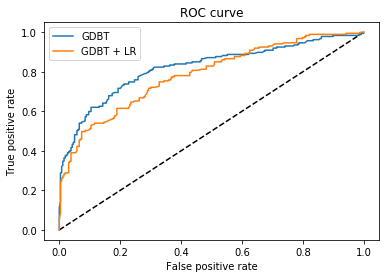

In [15]:
import matplotlib.pyplot as plt
# 將結果繪圖
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gdbt, tpr_gdbt, label='GDBT')
plt.plot(fpr_gdbt_lr, tpr_gdbt_lr, label='GDBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# 作業1
* 請對照範例，完成隨機森林的鐵達尼生存率預測，以及對應的葉編碼+邏輯斯迴歸

# 作業2
* 上述的結果，葉編碼是否有提高預測的正確性呢?